# Analyze Region 19 - Antarctic and Subantarctic Preprocessing

This notebook preprocesses mainland Antarctic data to look specifically for data by Huber et al (2017). This will give all the polygons for the Antarctic Penisula, which I have decided to use as the basis for the analysis of the Antartic mainland because it does not include the sub-Antarctic islands or the ice streams on the ice sheet that do not qualilfy as a glacier given the definition of glacier that I am using. Huber et al. (2017) excludes glaciers with connectivty level of 2. 

Huber, J., Cook, A. J., Paul, F., Zemp, M. (2017). A complete glacier inventory of the Antarctic Peninsula based on Landsat 7 images from 2000 to 2002 and other preexisting data sets. Earth System Science Data 9:115--131.


This notebook creates a shapefile of this subset of Antarctic mainland polygons.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "19"
region_name = "Antarctic and Subantarctic"

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 18
region_index_2 = 19

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta
    
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

## Open GLIMS "uncleaned" Data File

In [4]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/glims_region_" + region_number + ".shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

### Select the glaciers submitted by Huber

In [5]:
huber = glims_glaciers_df[glims_glaciers_df['submitters'].str.contains("Huber")]
huber.shape

(1725, 32)

In [6]:
# Clean the huber data
huber_clean_fp = "data/glims/processed/cleaned/glims_region_" + region_number + "_huber_cleaned.shp"
ws.clean_glims(huber, huber_clean_fp)

In [7]:
# Open cleaned huber shapefile to make sure it looks okay
huber_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_huber_cleaned.shp"
huber_glaciers_df = gpd.read_file(huber_glaciers_fn)
huber_glaciers_df.shape

(1724, 13)

In [17]:
# Find the 10 largest
ten_largest_df = huber_glaciers_df[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(10, 'db_area')
ten_largest_df.reset_index(drop=True, inplace=True)
ten_largest_df['glac_id'][0]

'G294015E69537S'

In [18]:
# Select 5 largest from GLIMS current region
#glims_largest_name_1 = glims_largest_csv.iloc[0:1]
huber_largest_pd_1 = huber_glaciers_df[huber_glaciers_df['glac_id']==ten_largest_df['glac_id'][0]]

#glims_largest_name_2 = glims_largest_csv.iloc[1:2]
huber_largest_pd_2 = huber_glaciers_df[huber_glaciers_df['glac_id']==ten_largest_df['glac_id'][1]]

#glims_largest_name_3 = glims_largest_csv.iloc[2:3]
huber_largest_pd_3 = huber_glaciers_df[huber_glaciers_df['glac_id']==ten_largest_df['glac_id'][2]]
    
#glims_largest_name_4 = glims_largest_csv.iloc[3:4]
huber_largest_pd_4 = huber_glaciers_df[huber_glaciers_df['glac_id']==ten_largest_df['glac_id'][3]]
    
#glims_largest_name_5 = glims_largest_csv.iloc[4:5]
huber_largest_pd_5 = huber_glaciers_df[huber_glaciers_df['glac_id']==ten_largest_df['glac_id'][4]]    

In [19]:
huber_largest_pd_1

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
1099,19,G294015E69537S,7018.37,7018.32,0.0,0.0,4.0,4.0,1358.0,3139.0,2002-12-31T00:00:00,Seller Glacier,"POLYGON Z ((-65.065175 -69.48543600000001 0, -..."


## Plot 5 Largest Huber GLIMS Glaciers

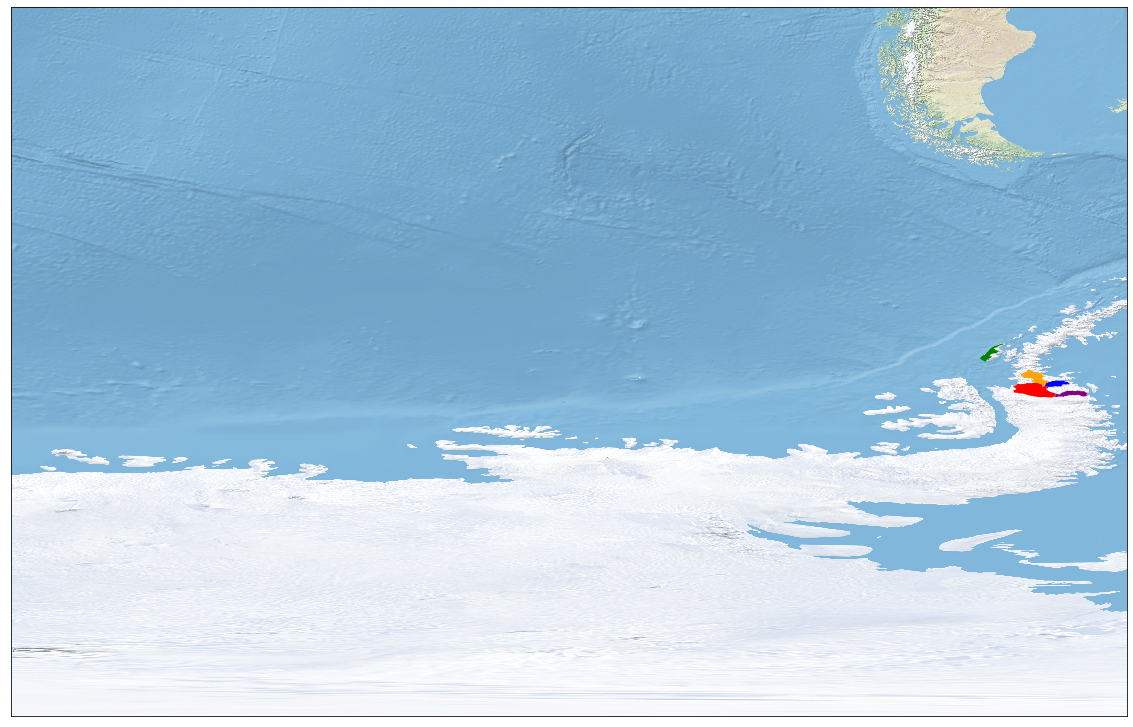

In [20]:
# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

huber_largest_pd_1.plot(ax=ax, color='red')
huber_largest_pd_2.plot(ax=ax, color='orange')
huber_largest_pd_3.plot(ax=ax, color='green')
huber_largest_pd_4.plot(ax=ax, color='purple')
huber_largest_pd_5.plot(ax=ax, color='blue')

plt.show()

## Save 5 Largest Huber Glaciers to shapefile
Note that the 5th largest is actually on an Antarctic Island so it will not be considered when selecting the top 3 for the mainland but this does not matter since it is 5th largest.

In [22]:
# Append the 5 biggest into one dataframe
largest_5 = huber_largest_pd_1.append([huber_largest_pd_2, huber_largest_pd_3, huber_largest_pd_4, 
                                       huber_largest_pd_5], ignore_index=True)

# Save 5 largest from specified region to shapefile
largest_5_fp = "data/glims/processed/largest/glims_region_" + region_number + "_huber_largest.shp"
largest_5.to_file(driver='ESRI Shapefile', filename=largest_5_fp)